In [1]:
import quandl

data = quandl.get("FMAC/FIX15YR")

## Question Five

Data Source: https://www.quandl.com/data/FMAC/FIX15YR-15-Year-Fix-Rate

Code: "FMAC/FIX15YR"

Use the data up until 2010 to train a regression model and use the data from 2011 onwards to test the model. You should regress on the US Interest Rate Column.

Describe model choices (Using Markdown Cells is Fine).

Display all statistics.

Display the results in a graph.  

Save the model using the `Model Saving` method, include the saved model.

Include all files in the `.zip` file.

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


## Construct a basic DNN model

First of all, we choose a bisic DNN model to fit the data in order to do this regression task. Then we seperate the daat into three parts: training set, validation set and test set. 

In [3]:
data.index = pd.to_datetime(data.index)
data = data.dropna()

In [4]:
data_train = data[data.index<=pd.to_datetime("2008-01-01")]

In [5]:
data_test = data[data.index>=pd.to_datetime("2011-01-01")]

In [6]:
data_val = data[(data.index<pd.to_datetime("2011-01-01"))*(data.index>pd.to_datetime("2008-01-01"))]

In [7]:
#y_train = preprocessing.scale(np.asarray(data_train["US Interest Rate"]))
y_train = np.asarray(data_train["US Interest Rate"])
x_train = preprocessing.scale(np.asarray(data_train.loc[:,"Fees & Points":]),axis=0)
#y_test = preprocessing.scale(np.asarray(data_test["US Interest Rate"]))
y_test = np.asarray(data_test["US Interest Rate"])
x_test = preprocessing.scale(np.asarray(data_test.loc[:,"Fees & Points":]),axis=0)
#y_val = preprocessing.scale(np.asarray(data_val["US Interest Rate"]))
y_val = np.asarray(data_val["US Interest Rate"])
x_val = preprocessing.scale(np.asarray(data_val.loc[:,"Fees & Points":]),axis=0)

Let's see the sequence of the label data. Our target is to fit the sequence by using the other features.

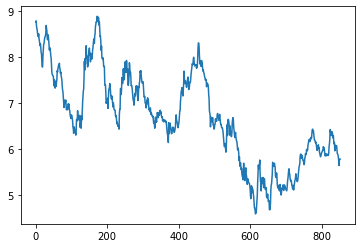

In [8]:
plt.plot(y_train)

Then we construc the tensor of the model. Note that we have 3 hidden layers and each hidden layer has a second regularization method and we use batch normalization to better fit the network.

In [16]:
model0 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(x_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(0.001)

model0.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss='mean_squared_error',
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
# )

We fit the model using the traing data and we also add a early stopping point that make the training stop when the validation set's error goes up for last 3 steps.

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model0.fit(
    x_train,y_train,
    validation_data =(x_val,y_val),
    epochs=70,
    callbacks=[early_stop]
)

Train on 853 samples, validate on 157 samples
Epoch 1/70
853/853 [==============================] - 1s 1ms/sample - loss: 47.0076 - mae: 6.6068 - mse: 44.0826 - val_loss: 23.8014 - val_mae: 4.5315 - val_mse: 20.9339
Epoch 2/70
853/853 [==============================] - 0s 63us/sample - loss: 44.3813 - mae: 6.4405 - mse: 41.5833 - val_loss: 22.2218 - val_mae: 4.3837 - val_mse: 19.5063
Epoch 3/70
853/853 [==============================] - 0s 64us/sample - loss: 41.6849 - mae: 6.2413 - mse: 39.0495 - val_loss: 19.9009 - val_mae: 4.1346 - val_mse: 17.3551
Epoch 4/70
853/853 [==============================] - 0s 63us/sample - loss: 38.5253 - mae: 5.9988 - mse: 36.0612 - val_loss: 17.2998 - val_mae: 3.8358 - val_mse: 14.9250
Epoch 5/70
853/853 [==============================] - 0s 64us/sample - loss: 34.9717 - mae: 5.7094 - mse: 32.6761 - val_loss: 14.8000 - val_mae: 3.5126 - val_mse: 12.5908
Epoch 6/70
853/853 [==============================] - 0s 65us/sample - loss: 31.1301 - mae: 5.3751 -

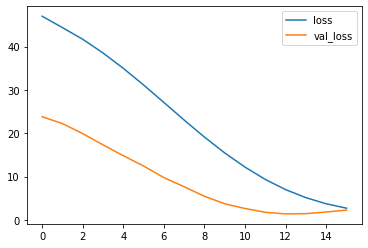

In [18]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

We compute the statistics of this model and plot the prediction data and real data.

In [19]:
loss, mae, mse = model0.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

261/1 - 0s - loss: 6.0873 - mae: 2.3739 - mse: 5.8160
Testing set Mean Abs Error:  2.37 MPG


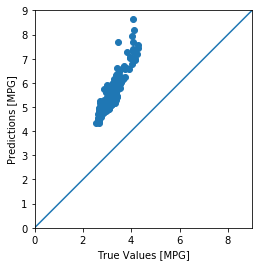

In [20]:
test_predictions = model0.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 9]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

As we can see, the test set's mse and mae are both higher than the validation set in the model fitting process which make sence. And our prediction are relatively higher than the real number. Although we tried different method to modify the model, we still can't reach the deal results.


## Construct a RNN model

This time we try to use the LSTM model to fit this data since it's time seriers. RNN can better handle the time seriers data and we try to construct a one time lag dataset to do this. Our features are all the columns in the original data set and our label is the next time's "US Interest Rate".

In [31]:
data2 = quandl.get("FMAC/FIX15YR")
data2 = data2.dropna()


In [80]:
data_new = pd.concat([data2.iloc[:,0].shift(-1),data2.iloc[:,:]],axis=1)

In [81]:
data_new = data_new.iloc[:-1,:]

In [82]:
data_new.columns = [data_new.columns[0]+" t+1"]+list(data_new.columns[1:])

In [83]:
scaler = preprocessing.StandardScaler()

In [84]:
train = scaler.fit_transform(np.asarray(data_new[data_new.index<=pd.to_datetime("2010-12-31")]))
test = scaler.fit_transform(np.asarray(data_new[data_new.index>=pd.to_datetime("2011-01-01")]))

In [85]:

# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss='mae', 
    optimizer='adam',
    metrics=['mae', 'mse']
)
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=50, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)


(1010, 1, 12) (1010,) (260, 1, 12) (260,)
Train on 1010 samples, validate on 260 samples
Epoch 1/50
1010/1010 - 2s - loss: 0.8665 - mae: 0.8665 - mse: 1.1195 - val_loss: 0.7088 - val_mae: 0.7088 - val_mse: 0.9135
Epoch 2/50
1010/1010 - 0s - loss: 0.5967 - mae: 0.5967 - mse: 0.5812 - val_loss: 0.6157 - val_mae: 0.6157 - val_mse: 0.6571
Epoch 3/50
1010/1010 - 0s - loss: 0.4158 - mae: 0.4158 - mse: 0.2882 - val_loss: 0.5466 - val_mae: 0.5466 - val_mse: 0.4835
Epoch 4/50
1010/1010 - 0s - loss: 0.3185 - mae: 0.3185 - mse: 0.1568 - val_loss: 0.4798 - val_mae: 0.4798 - val_mse: 0.3633
Epoch 5/50
1010/1010 - 0s - loss: 0.2671 - mae: 0.2671 - mse: 0.1051 - val_loss: 0.4100 - val_mae: 0.4100 - val_mse: 0.2715
Epoch 6/50
1010/1010 - 0s - loss: 0.2255 - mae: 0.2255 - mse: 0.0752 - val_loss: 0.3367 - val_mae: 0.3367 - val_mse: 0.1989
Epoch 7/50
1010/1010 - 0s - loss: 0.1809 - mae: 0.1809 - mse: 0.0510 - val_loss: 0.2723 - val_mae: 0.2723 - val_mse: 0.1461
Epoch 8/50
1010/1010 - 0s - loss: 0.1393 - 

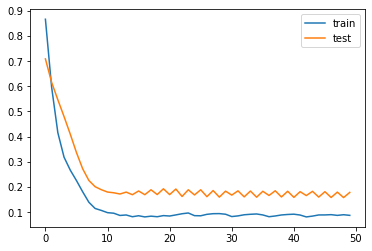

In [86]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [87]:
loss, mae, mse = model.evaluate(test_X, test_y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

260/1 - 0s - loss: 0.1108 - mae: 0.1785 - mse: 0.0650
Testing set Mean Abs Error:  0.18 MPG


The loss, mae and mse are all much smaller than the previous model. We should use this RNN model to fit the data. To better illustrate the comparison, we plot the test set data.

In [88]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]



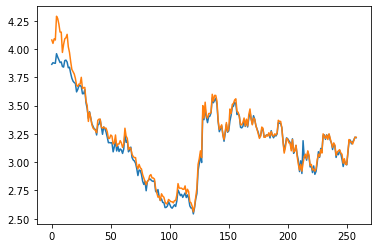

In [89]:

plt.plot(inv_yhat[1:])
plt.plot(inv_y[:-1])

The model we use at here is much more accurate than basic DNN model.

We both save the DNN and RNN model to reuse them in the future if we want.

In [90]:
model0.save("DNN_model.h5")
model.save("RNN_LSTM_model.h5")